In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
import argparse
import mw_ml as ml
import mw_ml.classification as mcl
import mwpak.vz as mvz
import mwpak.custom as mc
import mwpak.sc as msc
from mw_ml.classification import custom_performance_metric
from mw_ml import evaluate_prediction
from sklearn.model_selection import train_test_split
from mwpak import createFolder, logging
from matplotlib.gridspec import GridSpec

parser = argparse.ArgumentParser()
args, _ = parser.parse_known_args()

random_seed = 1024  # 1204
np.random.seed(random_seed)
warnings.filterwarnings("ignore")

In [2]:
args.input_features = "/Users/minwoopak/Library/CloudStorage/OneDrive-WeillCornellMedicine/FRP/ML_genotyping/test/ironthrone_out_pp.csv"
args.outdir = "/Users/minwoopak/Library/CloudStorage/OneDrive-WeillCornellMedicine/FRP/ML_genotyping/test"
createFolder(args.outdir)

args.max_allowed_fpr = 0.03
args.alpha = 0.8

In [5]:
# ! Features to drop when training the model
columns_to_drop = [
    "BC",
    "target",
    "sample",
    "expected_sample",
    "expected",
    "experiment",
    "is_non_mut",
    "genotype_merged",
]
# ! Models to run
models_to_run = [
    "logistic_regression",
    "random_forest",
    # "knn",
    # "naive_bayes",
    # "xgboost",
    # "mlp",
    # "gradient_boosting",
    # "hist_gradient_boosting",
    # "adaboost",
    # "svm",
    # "qda",
]
# ! Convert integer labels to back to original labels (if available, default is None)
int2label = {0: "FalsePositive", 1: "WT", 2: "MUT"}

In [6]:
total_df = pd.read_csv(args.input_features)
assert (
    total_df.query('genotype_merged == "MUT"')["Y_num"]
    .value_counts()
    .index.isin([0, 2])
    .all()
)
total_df.drop("Y", axis=1, inplace=True)
total_df.rename(columns={"Y_num": "Y"}, inplace=True)
total_df

,BC,target,sample,expected_sample,expected,experiment,is_non_mut,wt_reads_per_umi_avg_geneseq,wt_reads_per_umi_med_geneseq,wt_reads_per_umi_std_geneseq,...,amb_reads_per_umi_total_probebc,amb_reads_per_umi_count_probebc,wt_calls_geneseq,mut_calls_geneseq,amb_calls_geneseq,wt_calls_probebc,mut_calls_probebc,amb_calls_probebc,genotype_merged,Y
0,AAACAAGCAAATACCG,CALR,AML,MPN,0,Primary_FRPtest1,False,8.500000,8.5,6.500000,...,0.0,2,2,0,0,2,0,0,WT,1
1,AAACAAGCAATGTTCC,CALR,AML,MPN,0,Primary_FRPtest1,False,6.000000,6.0,1.000000,...,0.0,2,2,0,0,2,0,0,WT,1
2,AAACAAGCAGGTGACT,CALR,AML,MPN,0,Primary_FRPtest1,False,26.750000,23.5,18.171062,...,0.0,4,4,0,0,4,0,0,WT,1
3,AAACAAGCATATGGTG,CALR,AML,MPN,0,Primary_FRPtest1,False,4.000000,4.0,0.000000,...,0.0,1,1,0,0,1,0,0,WT,1
4,AAACAAGCATCAAGTG,CALR,AML,MPN,0,Primary_FRPtest1,False,30.333333,27.0,18.116904,...,0.0,3,3,0,0,3,0,0,WT,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13330,TTTGGACGTGTCCAGC,IDH2,AML,AML,1,Primary_FRPtest1,False,103.000000,103.0,0.000000,...,0.0,1,1,0,0,1,0,0,WT,1
13331,TTTGGCGGTCATGAAG,IDH2,AML,AML,1,Primary_FRPtest1,False,0.000000,0.0,0.000000,...,0.0,1,0,1,0,0,1,0,MUT,2
13332,TTTGTGAGTAATAGGT,IDH2,AML,AML,1,Primary_FRPtest1,False,3.600000,0.0,7.200000,...,0.0,5,1,4,0,1,4,0,MUT,2
13333,TTTGTGAGTACACCCA,IDH2,AML,AML,1,Primary_FRPtest1,False,29.000000,29.0,0.000000,...,0.0,1,1,0,0,1,0,0,WT,1


In [7]:
# === Predict for each target (across all experiments) === #
targets = total_df["target"].unique()
print(f"#Targets: {len(targets)}")
print(targets)

#Targets: 3
['CALR' 'CALR_enriched' 'IDH2']


In [8]:
skipped_targets = []
for target in targets:
    target_df = total_df[total_df["target"] == target]
    non_target_df = total_df[total_df["target"] != target]

    if target_df["expected_sample"].unique()[0] not in target_df["sample"].unique():
        print(f"Skipping {target} due to lack of cells in expected sample")
        skipped_targets.append(target)
        continue
    if (target_df["Y"] == 2).sum() <= 1:
        print(f"Skipping {target} due to lack of MUT in expected sample")
        skipped_targets.append(target)
        continue

    resultdir = os.path.join(args.outdir, target)
    createFolder(resultdir)
    logging(f"# === Target: {target} === #", resultdir, "log.txt")
    logging(
        total_df.query("target == @target")["genotype_merged"].value_counts(),
        resultdir,
        "log.txt",
    )

    # * ================================================================================ * #
    # * === First Run (Train: Half of target + Other targets & Test: The other half) === * #
    # * ================================================================================ * #
    # if any of the values other than 2 in 'Y' is equal to 1, duplicate that row to have two rows
    if (target_df["Y"] == 0).sum() == 1:
        target_df = pd.concat([target_df, target_df[target_df["Y"] == 0]])
    if (target_df["Y"] == 1).sum() == 1:
        target_df = pd.concat([target_df, target_df[target_df["Y"] == 1]])

    target_df_1, target_df_2 = train_test_split(
        target_df,
        test_size=0.5,
        stratify=target_df["Y"],
        random_state=random_seed,
    )

    logging(
        f"First Run: Train: {target_df_1.shape}, Test: {target_df_2.shape}",
        resultdir,
        "log.txt",
    )

    # Train: Half of target + Other targets, Test: The other half
    train_df = pd.concat([target_df_1, non_target_df])
    test_df = target_df_2.copy()

    # ! Removing Unprofiled cells from Training data
    logging("Removing Unprofiled cells from training data", resultdir, "log.txt")
    train_df = train_df.query('genotype_merged != "Unprofiled"')
    # test_df = test_df.query('genotype_merged != "Unprofiled"')
    logging("Train set Labels before balancing by label:", resultdir, "log.txt")
    logging(train_df["Y"].value_counts(), resultdir, "log.txt")

    # * Balance by Label (WT, MUT, False Positive)
    train_df = ml.balance_by_label(
        train_df,
        "Y",
        balance_values=[0, 2],
        min_freq=100,
        random_seed=random_seed,
        visualize=False,
    )

    logging("Train set Labels after balancing by label:", resultdir, "log.txt")
    logging(train_df["Y"].value_counts(), resultdir, "log.txt")

    train_df.to_csv(os.path.join(resultdir, f"{target}_1_train.csv"), index=False)
    test_df.to_csv(os.path.join(resultdir, f"{target}_1_test.csv"), index=False)

    # === Drop columns that are not features === #
    train_df = train_df.drop(columns=columns_to_drop)
    test_df = test_df.drop(columns=columns_to_drop)

    (
        test_res_1,
        fitted_models,
        _best_model_name,
        _y_pred_best,
        _y_pred_prob_best,
        _best_clf,
    ) = mcl.train_classification_model(
        train_df,
        test_df,
        resultdir,
        target_column="Y",
        y_value_of_interest=2,
        models_to_run=models_to_run,
        ensemble_hard=True,
        ensemble_soft=True,
        random_seed=random_seed,
    )

    # * ================================================================================= * #
    # * === Second Run (Train: Half of target + Other targets & Test: The other half) === * #
    # * ================================================================================= * #
    logging(
        f"Second Run: Train: {target_df_2.shape}, Test: {target_df_1.shape}",
        resultdir,
        "log.txt",
    )

    # Train: Half of target + Other targets, Test: The other half
    train_df = pd.concat([target_df_2, non_target_df])
    test_df = target_df_1.copy()

    # ! Removing Unprofiled cells from Training data
    logging("Removing Unprofiled cells from training data", resultdir, "log.txt")
    train_df = train_df.query('genotype_merged != "Unprofiled"')
    # test_df = test_df.query('genotype_merged != "Unprofiled"')
    logging("Train set Labels before balancing by label:", resultdir, "log.txt")
    logging(train_df["Y"].value_counts(), resultdir, "log.txt")

    # * Balance by Label (WT, MUT, False Positive)
    train_df = ml.balance_by_label(
        train_df,
        "Y",
        balance_values=[0, 2],
        min_freq=100,
        random_seed=random_seed,
        visualize=False,
    )

    logging("Train set Labels after balancing by label:", resultdir, "log.txt")
    logging(train_df["Y"].value_counts(), resultdir, "log.txt")

    train_df.to_csv(os.path.join(resultdir, f"{target}_2_train.csv"), index=False)
    test_df.to_csv(os.path.join(resultdir, f"{target}_2_test.csv"), index=False)

    # === Drop columns that are not features === #
    train_df = train_df.drop(columns=columns_to_drop)
    test_df = test_df.drop(columns=columns_to_drop)

    (
        test_res_2,
        fitted_models,
        _best_model_name,
        _y_pred_best,
        _y_pred_prob_best,
        _best_clf,
    ) = mcl.train_classification_model(
        train_df,
        test_df,
        resultdir,
        target_column="Y",
        y_value_of_interest=2,
        models_to_run=models_to_run,
        ensemble_hard=True,
        ensemble_soft=True,
        random_seed=random_seed,
    )

    test_res = pd.concat([test_res_1, test_res_2])
    # ! Remove 'best' columns
    test_res = test_res[test_res.columns[~test_res.columns.str.contains("best")]]

    # * ================================================ * #
    # * === Gather all predictions and probabilities === * #
    # * ================================================ * #
    pred_cols = test_res.columns[test_res.columns.str.contains("_pred")].tolist()
    prob_cols = test_res.columns[test_res.columns.str.contains("_prob_")].tolist()
    conf_cols = test_res.columns[test_res.columns.str.contains("_conf")].tolist()

    assert test_res.index.isin(target_df.index).all()
    test_res = pd.merge(
        total_df.loc[
            test_res.index,
            columns_to_drop,
        ],
        test_res[pred_cols + prob_cols + conf_cols + ["Y"]],
        left_index=True,
        right_index=True,
    ).reset_index(drop=True)

    # * === Label mapping === #
    if int2label is not None:
        # Map integer to label for each prediction column
        for col in pred_cols:
            test_res[col] = test_res[col].map(int2label)
        test_res["Y"] = test_res["Y"].map(int2label)

        # Map integer to label in the pred_proba column names
        int2label_proba = {
            c: "_".join(c.split("_")[:-1] + [int2label[int(c.split("_")[-1])]])
            for c in prob_cols
        }
        test_res = test_res.rename(columns=int2label_proba)

    test_res.to_csv(os.path.join(resultdir, f"{target}_test_results.csv"), index=False)

    # * ================================================================= * #
    # * ====== Adjust the prediction based on the confidence score ====== * #
    # * ================================================================= * #
    # ! Requires `expected` column (containing: 0 or 1)

    # if all cells are in the expected cell group, or all cells are in the non-expected cell group,
    # then the prediction cannot be adjusted
    if test_res["expected"].nunique() == 1:
        print(
            "All cells are either in the expected cell group or all cells are in the non-expected cell group.\n"
            "The prediction cannot be adjusted."
        )
        continue

    # For each of the models, adjust the prediction based on the confidence
    # for the given threshold of MUT prediction probability, reassign the prediction between WT and MUT
    models = [c.replace("_pred", "") for c in pred_cols]

    for model_name in models:
        pred_col = f"{model_name}_pred"
        if model_name == "ensemble_hard":
            prob_col = f"{model_name}_confidence"
        else:
            prob_col = f"{model_name}_prob_MUT"

        # Calculate false positive rate
        false_positive_rate = (
            test_res.query("expected == 0")[pred_col]
            .value_counts(normalize=True)
            .get("MUT")
        )
        true_positive_rate = (
            test_res.query("expected == 1")[pred_col]
            .value_counts(normalize=True)
            .get("MUT")
        )
        if false_positive_rate is None:
            test_res[f"{pred_col}_adj"] = test_res[pred_col]
            continue
        if true_positive_rate is None:
            true_positive_rate = 0
        specificity = true_positive_rate - false_positive_rate

        # * If there are many false positives, adjust the prediction reduce it (less MUT)
        if false_positive_rate > args.max_allowed_fpr:
            # Find the threshold that minimizes the false positive rate without losing too much sensitivity
            for mut_threshold in np.linspace(
                0.1, 1.0, 50
            ):  # stricter (less MUT: Some MUT -> FalsePositive)
                mut_mask = test_res[prob_col] >= mut_threshold

                # values that were originally predicted as MUT but have low confidence are reassigned as FalsePositive
                test_res[f"{pred_col}_tmp"] = np.where(
                    (test_res[pred_col] == "MUT") & ~mut_mask,
                    "FalsePositive",
                    test_res[pred_col],
                )
                if "MUT" not in test_res[f"{pred_col}_tmp"].unique():
                    break
                assert test_res[f"{pred_col}_tmp"].value_counts().get(
                    "MUT"
                ) <= test_res[f"{pred_col}"].value_counts().get("MUT")

                # re-examine the false positive rate
                false_positive_rate_tmp = (
                    test_res.query("expected == 0")[f"{pred_col}_tmp"]
                    .value_counts(normalize=True)
                    .get("MUT")
                )
                true_positive_rate_tmp = (
                    test_res.query("expected == 1")[f"{pred_col}_tmp"]
                    .value_counts(normalize=True)
                    .get("MUT")
                )
                if false_positive_rate_tmp is None or true_positive_rate_tmp is None:
                    break
                specificity_tmp = true_positive_rate_tmp - false_positive_rate_tmp

                # Only adjust if we didn't lose too much true positive MUT calls and specificity is improved
                if (true_positive_rate - true_positive_rate_tmp < 0.2) and (
                    specificity_tmp > specificity
                ):
                    test_res[f"{pred_col}_adj"] = test_res[f"{pred_col}_tmp"]
                if false_positive_rate_tmp < args.max_allowed_fpr:
                    break
        # * If false positive rate is low, adjust to get more MUT
        elif false_positive_rate < 0.02:
            # Decrease the threshold to increase the number of MUT but keep the false positive rate low
            for mut_threshold in np.linspace(
                1.0, 0.01, 50
            ):  # looser (more MUT: Some WT/FaslePositive -> MUT)
                mut_mask = test_res[prob_col] >= mut_threshold

                # values that were originally predicted as WT or FalsePositive but have relatively high confidence are reassigned as MUT
                test_res[f"{pred_col}_tmp"] = np.where(
                    (test_res[pred_col] != "MUT") & mut_mask,
                    "MUT",
                    test_res[pred_col],
                )

                # examine false & true positive rates
                false_positive_rate_tmp = (
                    test_res.query("expected == 0")[f"{pred_col}_tmp"]
                    .value_counts(normalize=True)
                    .get("MUT")
                )
                true_positive_rate_tmp = (
                    test_res.query("expected == 1")[f"{pred_col}_tmp"]
                    .value_counts(normalize=True)
                    .get("MUT")
                )
                if true_positive_rate_tmp is None:
                    true_positive_rate_tmp = 0
                specificity_tmp = true_positive_rate_tmp - false_positive_rate_tmp

                # Only adjust false positive is still low and specificity is improved
                if (
                    false_positive_rate_tmp < args.max_allowed_fpr
                    and specificity_tmp >= specificity
                ):
                    test_res[f"{pred_col}_adj"] = test_res[f"{pred_col}_tmp"]
                    assert true_positive_rate_tmp >= true_positive_rate

        if f"{pred_col}_adj" not in test_res.columns:
            test_res[f"{pred_col}_adj"] = test_res[pred_col]

    test_res.drop(
        columns=test_res.columns[test_res.columns.str.contains("_tmp")],
        inplace=True,
    )

    # * === Save Best Model Prediction in 'best_pred_adj' column === #
    # Sort models by performance
    performance_dict = {}
    for model_name in models:
        performance = custom_performance_metric(
            test_res["Y"],
            test_res[
                f"{model_name}_pred_adj"
            ],  # ! For sorting, use the "adjusted" prediction
            y_value_of_interest="MUT",
            alpha=args.alpha,
        )
        performance_dict[model_name] = performance
    models_sorted = [
        k
        for k, v in sorted(
            performance_dict.items(), key=lambda item: item[1], reverse=True
        )
    ]
    best_model = models_sorted[0]
    test_res["best_pred_adj"] = test_res[f"{best_model}_pred_adj"]

    test_res.to_csv(
        os.path.join(resultdir, f"{target}_test_results_adjusted.csv"), index=False
    )

# === Target: CALR === #
genotype_merged
WT            6421
MUT             61
Unprofiled       1
Name: count, dtype: int64
First Run: Train: (3241, 45), Test: (3242, 45)
Removing Unprofiled cells from training data
Train set Labels before balancing by label:
Y
1    8507
2    1512
0      72
Name: count, dtype: int64
Train set Labels after balancing by label:
Y
1    1512
0    1512
2    1512
Name: count, dtype: int64

Running hyperparameter search for logistic_regression...
logistic_regression - : Performance: 0.6080
Classification Report for logistic_regression:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       1.00      1.00      1.00      3211
           2       0.62      0.45      0.53        11

    accuracy                           1.00      3242
   macro avg       0.78      0.77      0.77      3242
weighted avg       1.00      1.00      1.00      3242


Running hyperparameter search for random_forest...

In [9]:
# * ====== Aggregate Results ====== #
agg_pred_df = []
for target in targets:
    resultdir = os.path.join(args.outdir, target)

    # check if resultdir exists
    if not os.path.exists(resultdir):
        if target in skipped_targets:
            print(
                f"{target} was not denoised using ML. Adding IronThrone results as the final genotypes."
            )
            test_res = total_df[total_df["target"] == target]
            test_res["best_pred_adj"] = test_res["genotype_merged"].copy()
        else:
            raise FileNotFoundError(f"{target} does not have a result directory.")
    else:
        test_res = pd.read_csv(
            os.path.join(resultdir, f"{target}_test_results_adjusted.csv")
        )
    agg_pred_df.append(test_res)

agg_pred_df = pd.concat(agg_pred_df, join="outer").drop_duplicates()

createFolder(os.path.join(args.outdir, "aggregated"))
agg_pred_df.to_csv(
    os.path.join(args.outdir, "aggregated", "prediction_results_aggregated.csv"),
    index=False,
)

In [10]:
# * ====== Save Best Model Prediction in 'best_pred_adj' column ====== * #
pred_cols = agg_pred_df.columns[agg_pred_df.columns.str.contains("_pred")].tolist()
pred_cols = [c for c in pred_cols if "_adj" in c and "best" not in c]
# models = [c.replace("_pred", "") for c in pred_cols]
targets = agg_pred_df["target"].unique()
# targets = ['SF3B1'] #!!!!!

# ! Recover Unprofiled cells (Model prediction outputs are only among WT, MUT, and FalsePositive)
final_pred_df = []
for target in targets:
    test_res = agg_pred_df[agg_pred_df["target"] == target]

    performance_dict = {}
    for pred_col in pred_cols:
        # ! Cells that are not predicted as MUT and that are Unprofiled in the genotype_merged column are set back to Unprofiled
        test_res[pred_col] = test_res.apply(
            lambda row: "Unprofiled"
            if row["genotype_merged"] == "Unprofiled" and row[pred_col] != "MUT"
            else row[pred_col],
            axis=1,
        )
        # Rest of the FalsePositive cells are set to WT
        test_res[pred_col] = test_res[pred_col].str.replace("FalsePositive", "WT")
        assert test_res["BC"].isin(total_df["BC"]).all()

        # === Sort models by performance === #
        test_res["gt"] = test_res["Y"].str.replace("FalsePositive", "WT")

        # Exclude Unprofiled
        test_tmp = test_res.query(f'{pred_col} != "Unprofiled"')

        performance = custom_performance_metric(
            test_tmp["gt"],
            test_tmp[pred_col],
            y_value_of_interest="MUT",
            alpha=args.alpha,
        )
        performance_dict[pred_col] = performance
    models_sorted = [
        k
        for k, v in sorted(
            performance_dict.items(), key=lambda item: item[1], reverse=True
        )
    ]
    best_model = models_sorted[0]
    test_res["best_pred_adj"] = test_res[best_model]
    final_pred_df.append(test_res)
    print(f"Target: {target}, Best Model: {best_model}")
final_pred_df = pd.concat(final_pred_df)

final_pred_df["genotype_merged"] = final_pred_df["genotype_merged"].str.replace(
    "Ambiguous", "Unprofiled"
)

Target: CALR, Best Model: ensemble_hard_pred_adj
Target: CALR_enriched, Best Model: ensemble_hard_pred_adj
Target: IDH2, Best Model: ensemble_soft_pred_adj


In [11]:
# ! Recover Unprofiled cells (Model prediction outputs are only among WT, MUT, and FalsePositive)
# ! Cells that are not predicted as MUT and that are Unprofiled in the genotype_merged column are set back to Unprofiled
final_pred_df["best_pred_adj"] = final_pred_df.apply(
    lambda row: "Unprofiled"
    if row["genotype_merged"] == "Unprofiled" and row["best_pred_adj"] != "MUT"
    else row["best_pred_adj"],
    axis=1,
)
# Rest of the FalsePositive cells are set to WT
final_pred_df["best_pred_adj"] = final_pred_df["best_pred_adj"].str.replace(
    "FalsePositive", "WT"
)
assert final_pred_df["BC"].isin(total_df["BC"]).all()

# Y values of the cells that were called MUT in the expected cell group by ironthrone but are predicted as WT by the model are set to WT
# (Since they are false positive noises)
final_pred_df.loc[
    (final_pred_df["expected"] == 1)
    & (final_pred_df["Y"] == "MUT")
    & (final_pred_df["best_pred_adj"] != "MUT"),
    "Y",
] = "WT"

# Remove unprofiled cells from the final genotypes
final_pred_df = final_pred_df[
    (final_pred_df["genotype_merged"].isin(["WT", "MUT"]))
    | (final_pred_df["best_pred_adj"] == "MUT")
]

createFolder(os.path.join(args.outdir, "aggregated"))
final_pred_df.to_csv(
    os.path.join(
        args.outdir, "aggregated", f"final_prediction_results_alpha_{args.alpha}.csv"
    ),
    index=False,
)

In [12]:
final_pred_df

,BC,target,sample,expected_sample,expected,experiment,is_non_mut,genotype_merged,logistic_regression_pred,random_forest_pred,...,ensemble_soft_prob_WT,ensemble_soft_prob_MUT,ensemble_hard_confidence,Y,logistic_regression_pred_adj,random_forest_pred_adj,ensemble_hard_pred_adj,ensemble_soft_pred_adj,best_pred_adj,gt
0,AGCTAATCATGCGCCT,CALR,AML,MPN,0,Primary_FRPtest1,False,WT,WT,WT,...,0.989988,0.004055,1.0,WT,WT,WT,WT,WT,WT,WT
1,ATGCGATAGGGATTTA,CALR,AML,MPN,0,Primary_FRPtest1,False,WT,WT,WT,...,0.925209,0.003044,1.0,WT,WT,WT,WT,WT,WT,WT
2,GTAACTAAGCATCTTG,CALR,AML,MPN,0,Primary_FRPtest1,False,WT,WT,WT,...,0.938421,0.006208,1.0,WT,WT,WT,WT,WT,WT,WT
3,GACATAATCCTCAATG,CALR,AML,MPN,0,Primary_FRPtest1,False,WT,WT,WT,...,0.931683,0.022375,1.0,WT,WT,WT,WT,WT,WT,WT
4,ATAACCCGTCCAGCTA,CALR,AML,MPN,0,Primary_FRPtest1,False,WT,WT,WT,...,0.962590,0.013681,1.0,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,AGCTGCAAGACAACTA,IDH2,AML,AML,1,Primary_FRPtest1,False,MUT,MUT,MUT,...,0.003337,0.901814,1.0,MUT,MUT,MUT,MUT,MUT,MUT,MUT
2047,ATTTGTCAGGTGCACA,IDH2,AML,AML,1,Primary_FRPtest1,False,MUT,MUT,MUT,...,0.038950,0.811309,1.0,MUT,MUT,MUT,MUT,MUT,MUT,MUT
2048,TCGCTTGCAGATTCGA,IDH2,AML,AML,1,Primary_FRPtest1,False,MUT,MUT,MUT,...,0.023461,0.852659,1.0,MUT,MUT,MUT,MUT,MUT,MUT,MUT
2049,TAGGTTAAGGTCTTTG,IDH2,AML,AML,1,Primary_FRPtest1,False,MUT,MUT,MUT,...,0.045721,0.807008,1.0,MUT,MUT,MUT,MUT,MUT,MUT,MUT


In [13]:
final_pred_df["best_pred_adj"].value_counts()

best_pred_adj
WT     11887
MUT     1441
Name: count, dtype: int64

### Visualize: Without Unprofiled

In [ ]:
# final_pred_df = pd.read_csv(
#     os.path.join(
#         args.outdir, "aggregated", f"final_prediction_results_alpha_{args.alpha}.csv"
#     ),
# )

In [25]:
x_var = "expected"

In [ ]:
final_pred_df["expected"] = final_pred_df["expected"].replace(
    {0: "Not-Expected", 1: "Expected"}
)

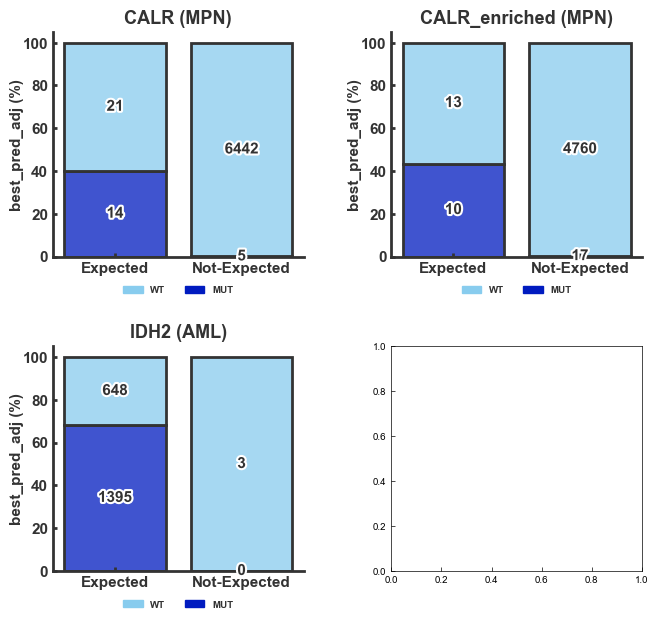

In [ ]:
# === Visualize IronThrone Genoyptes === #
composition_var = "best_pred_adj"

targets = final_pred_df["target"].unique()

n_rows = math.ceil(len(targets) / 2)
n_cols = 2
fig = plt.figure(figsize=(n_cols * 3.8, n_rows * 3.5))
gs = GridSpec(
    n_rows, n_cols, figure=fig, hspace=0.4, wspace=0.35
)  # Adjust hspace and wspace here
axes = [fig.add_subplot(gs[i, j]) for i in range(n_rows) for j in range(n_cols)]
for i, target in enumerate(targets):
    target_df = final_pred_df.query(f"target == '{target}'").query(
        f'{composition_var} != "Unprofiled"'
    )  # ! Exclude Unprofiled cells
    expected_sample = target_df["expected_sample"].unique()[0]
    assert target_df["target"].nunique() == 1

    _ = mvz.plot_composition(
        target_df,
        x_var,
        composition_var,
        composition_var_order=["WT", "MUT"],  # "Unprofiled",
        title=f"{target} ({expected_sample})",
        # figsize=(4, 6),
        ax=axes[i],
        # outdir=resultdir,
        palette={"MUT": "#001bc0", "WT": "#8ce", "Unprofiled": "lightgrey"},
        annotate_counts=True,
    )
plt.savefig(
    os.path.join(
        args.outdir, "refined_genotype_proportions_in_expected_cell_group.png"
    ),
    dpi=150,
    bbox_inches="tight",
)

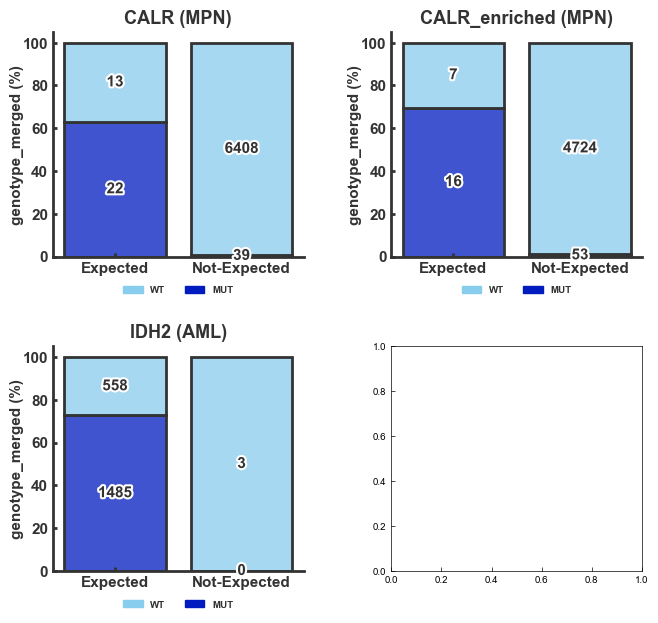

In [ ]:
# === Visualize IronThrone Genoyptes === #
composition_var = "genotype_merged"

targets = final_pred_df["target"].unique()

n_rows = math.ceil(len(targets) / 2)
n_cols = 2
fig = plt.figure(figsize=(n_cols * 3.8, n_rows * 3.5))
gs = GridSpec(
    n_rows, n_cols, figure=fig, hspace=0.4, wspace=0.35
)  # Adjust hspace and wspace here
axes = [fig.add_subplot(gs[i, j]) for i in range(n_rows) for j in range(n_cols)]
for i, target in enumerate(targets):
    target_df = final_pred_df.query(f"target == '{target}'").query(
        f'{composition_var} != "Unprofiled"'
    )  # ! Exclude Unprofiled cells
    expected_sample = target_df["expected_sample"].unique()[0]
    assert target_df["target"].nunique() == 1

    _ = mvz.plot_composition(
        target_df,
        x_var,
        composition_var,
        composition_var_order=["WT", "MUT"],  # "Unprofiled",
        title=f"{target} ({expected_sample})",
        # figsize=(4, 6),
        ax=axes[i],
        # outdir=resultdir,
        palette={"MUT": "#001bc0", "WT": "#8ce", "Unprofiled": "lightgrey"},
        annotate_counts=True,
    )
plt.savefig(
    os.path.join(
        args.outdir, "initial_genotype_proportions_in_expected_cell_group.png"
    ),
    dpi=150,
    bbox_inches="tight",
)

---

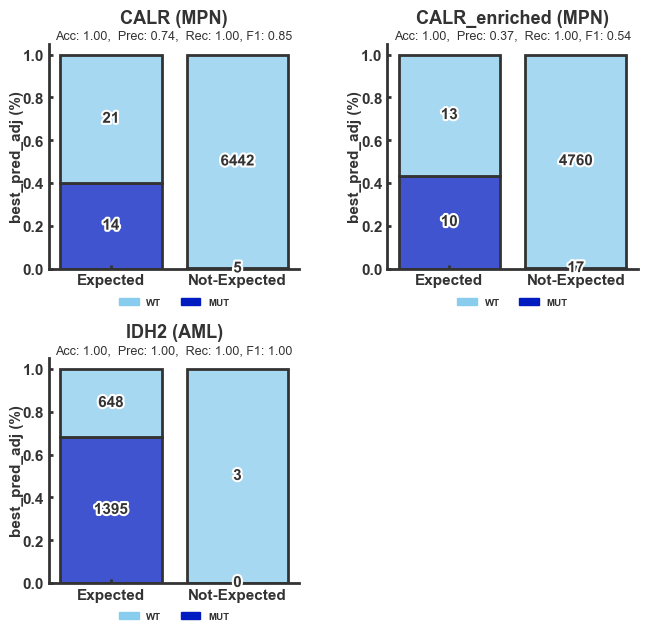

In [ ]:
# * === Visualize Adjusted Prediction Results === #
targets = final_pred_df["target"].unique()

n_rows = math.ceil(len(targets) / 2)
n_cols = 2
fig = plt.figure(figsize=(n_cols * 3.8, n_rows * 3.5))
gs = GridSpec(
    n_rows, n_cols, figure=fig, hspace=0.4, wspace=0.35
)  # Adjust hspace and wspace here
axes = [fig.add_subplot(gs[i, j]) for i in range(n_rows) for j in range(n_cols)]
for i, target in enumerate(targets):
    target_df = final_pred_df.query(f"target == '{target}'")
    expected_sample = target_df["expected_sample"].unique()[0]
    assert target_df["target"].nunique() == 1

    # Input
    x_var = "expected"  # "sample" # is_non_mut_group
    composition_var = "best_pred_adj"

    # Calculate performance metrics
    tmp = target_df.copy()
    # ! Redefine label ('gt' column)
    tmp["Y"] = tmp["Y"].str.replace("FalsePositive", "WT")
    tmp["gt"] = tmp["Y"].copy()
    tmp.loc[(tmp["expected"] == 1) & (tmp[composition_var] == "MUT"), "gt"] = "MUT"

    tmp[composition_var] = tmp[composition_var].replace("Unprofiled", "WT")
    acc, prec, recall, f1, conf_matrix = evaluate_prediction(
        tmp,
        pred_col=composition_var,
        y_col="gt",
        labels=["WT", "MUT"],
        pos_label="MUT",
        report=False,
    )
    metrics_report = (
        f"Acc: {acc:.2f},  Prec: {prec:.2f},  Rec: {recall:.2f}, F1: {f1:.2f}"
    )

    target_df = target_df.query(
        f'{composition_var} != "Unprofiled"'
    )  # ! Exclude Unprofiled cells

    _ = mc.plot_composition(
        target_df,
        x_var,
        composition_var,
        composition_var_order=["WT", "MUT"],  # "Unprofiled",
        title=f"{target} ({expected_sample})",
        ax=axes[i],
        palette={"MUT": "#001bc0", "WT": "#8ce", "Unprofiled": "lightgrey"},
        annotate_counts=True,
    )
    x_mid = (axes[i].get_xlim()[0] + axes[i].get_xlim()[1]) / 2
    axes[i].text(
        x=x_mid,
        y=1.075,
        s=metrics_report,
        ha="center",
        size=9,
        # weight="bold",
        color="0.2",
    )
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.savefig(
    os.path.join(
        args.outdir,
        "refined_genotype_proportions_in_expected_cell_group_2.pdf",
    ),
    dpi=300,
    bbox_inches="tight",
)
plt.show()